# FEATURE SELECTION

In [1]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sequential_backward_selection import SBS
from pprint import pprint
from time import time
import pandas as pd
import numpy as np
import pickle

from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt
% matplotlib inline 

## LOAD DATA

In [2]:
df = pd.read_csv('data/wheat-2013-supervised-edited.csv')
df.drop(df.columns[0],axis=1,inplace=True)
df.head()

,Latitude,Longitude,apparentTemperatureMax,apparentTemperatureMin,cloudCover,dewPoint,humidity,precipIntensity,precipIntensityMax,precipProbability,...,precipTypeIsSnow,pressure,temperatureMax,temperatureMin,visibility,windBearing,windSpeed,NDVI,DayInSeason,Yield
0,46.811686,-118.695237,35.70,20.85,0.00,29.53,0.91,0.0000,0.0000,0.00,...,0,1027.13,35.70,27.48,2.46,214,1.18,134.110657,0,35.7
1,46.929839,-118.352109,35.10,26.92,0.00,29.77,0.93,0.0001,0.0019,0.05,...,0,1026.87,35.10,26.92,2.83,166,1.01,131.506592,0,35.7
2,47.006888,-118.510160,33.38,26.95,0.00,29.36,0.94,0.0001,0.0022,0.06,...,1,1026.88,33.38,26.95,2.95,158,1.03,131.472946,0,35.7
3,47.162342,-118.699677,28.05,25.93,0.91,29.47,0.94,0.0002,0.0039,0.15,...,1,1026.37,33.19,27.17,2.89,153,1.84,131.288300,0,35.7
4,47.157512,-118.434056,28.83,25.98,0.91,29.86,0.94,0.0003,0.0055,0.24,...,0,1026.19,33.85,27.07,2.97,156,1.85,131.288300,0,35.7


## ALGORITHMS

In [3]:
models = {}
models['Linear Regression'] = LinearRegression()
models['Gradient Boost'] = GradientBoostingRegressor(random_state=42)
models['Random Forest'] = RandomForestRegressor(random_state=42)

## FEATURE EVALUATION

In [4]:
def show_feat_importances(name, trained_model,feat_labels):
    plt.figure(figsize=(10,5))
    if name == 'Linear Regression':
        importances = trained_model.coef_
        plt.ylabel('Coefficients')
    else:
        importances = trained_model.feature_importances_
        plt.ylabel('Importances')
    indices = np.argsort(importances)[::-1]
    plt.bar(range(len(feat_labels)),importances[indices],color='lightblue',align='center')
    plt.xticks(range(len(feat_labels)),feat_labels[indices],rotation=90)
    plt.xlim([-1,len(feat_labels)])
    plt.tight_layout()
    plt.title('FEATURE IMPORTANCE | MODEL:{}'.format(name))
    plt.grid()
    plt.show()

### FEATURE EVALUATION: Round#1

The model scores alone tipped me off to further investigate the longitude and latitude features. In my review, I concluded that longitude and latitude was a source of leakage (where features are directly related to the target). As a result, I removed longitude and latitude as features in Round#2 of model/feature evaluation.

################################### Gradient Boost ##########################################
RUN_TIME:437.020871878sec 	 TEST_SCORE:0.93 	 TRAIN_SCORE:0.93


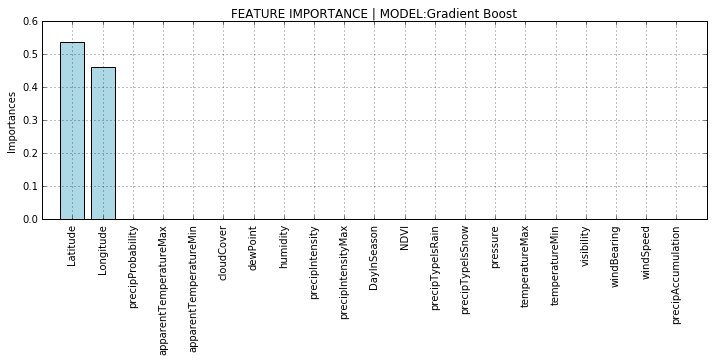

################################### Random Forest ##########################################
RUN_TIME:586.046509981sec 	 TEST_SCORE:1.0 	 TRAIN_SCORE:1.0


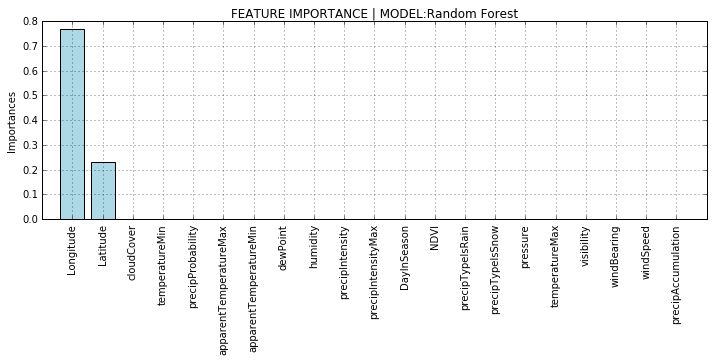

################################### Linear Regression ##########################################
RUN_TIME:587.957453966sec 	 TEST_SCORE:0.22 	 TRAIN_SCORE:0.23


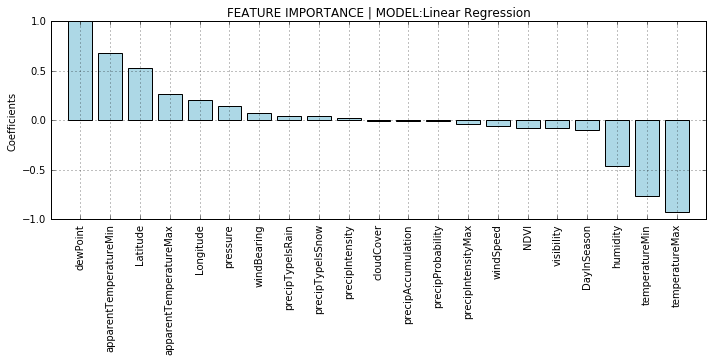

In [5]:
start_time = time()
X = np.matrix(df.ix[:,:-1])
y = np.array(df.ix[:,-1])
X_std = StandardScaler().fit_transform(X)
y_std = StandardScaler().fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X_std,y_std,test_size=0.25,random_state=42)
for name,model in models.items():
    results= model.fit(X_train,y_train)
    test_score = model.score(X_test,y_test)
    train_score = np.mean(cross_val_score(model,X_train,y_train,cv=8))
    print '################################### {} ##########################################'.format(name)
    print 'RUN_TIME:{}sec \t TEST_SCORE:{} \t TRAIN_SCORE:{}'.format(time()-start_time,test_score.round(2),train_score.round(2))
    show_feat_importances(name,results,df.columns[:-1])

### FEATURE EVALUATION: Round#2

In this round, it is apparent that the "precip..." features are on the lower end of importance. I will use this information to help me remove features after I run the sequential backward selection (SBS), a feature selection algorithm.

################################### Gradient Boost ##########################################
RUN_TIME:415.282940865sec 	 TEST_SCORE:0.27 	 TRAIN_SCORE:0.27


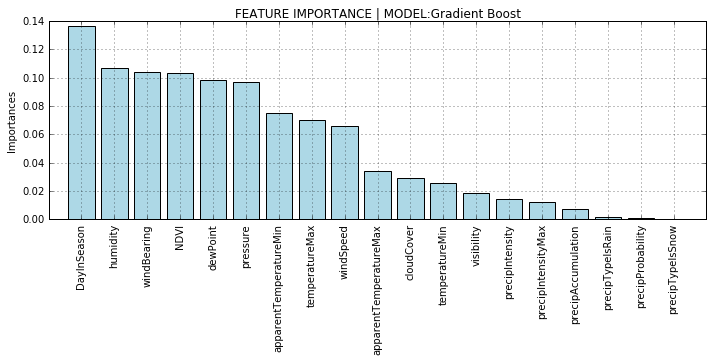

################################### Random Forest ##########################################
RUN_TIME:640.647248983sec 	 TEST_SCORE:0.84 	 TRAIN_SCORE:0.83


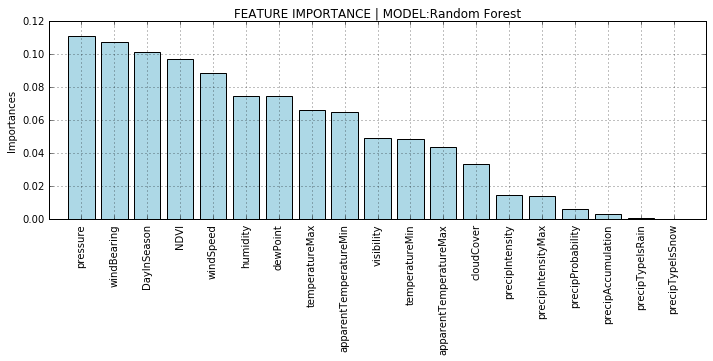

################################### Linear Regression ##########################################
RUN_TIME:642.419631004sec 	 TEST_SCORE:0.13 	 TRAIN_SCORE:0.14


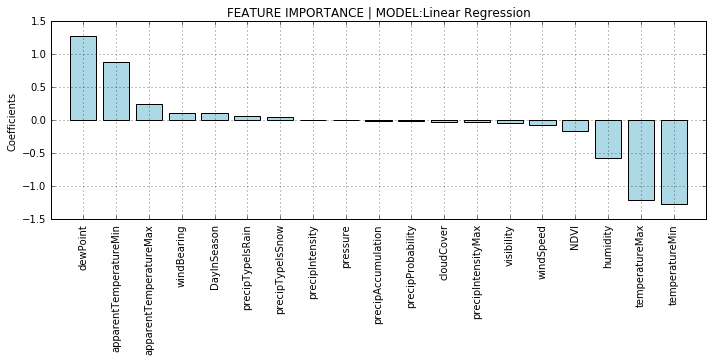

In [6]:
start_time = time()
X = np.matrix(df.ix[:,2:-1])
y = np.array(df.ix[:,-1])
X_std = StandardScaler().fit_transform(X)
y_std = StandardScaler().fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X_std,y_std,test_size=0.25,random_state=42)
for name,model in models.items():
    results= model.fit(X_train,y_train)
    test_score = model.score(X_test,y_test)
    train_score = np.mean(cross_val_score(model,X_train,y_train,cv=8))
    print '################################### {} ##########################################'.format(name)
    print 'RUN_TIME:{}sec \t TEST_SCORE:{} \t TRAIN_SCORE:{}'.format(time()-start_time,test_score.round(2),train_score.round(2))
    show_feat_importances(name,results,df.columns[2:-1])

## Sequential Backward Selection (SBS)

The sequential backward selection (SBS) is a feature selection technique that utilizes the greedy algorithm approach to optimize the score for a model given k features.

In the graph shown below, the (test) scores plateau at the...
* MODEL: Random Forest     ==> plateau: 5th iteration (4 features removed)
* MODEL: Linear Regression ==> plateau: 9th iteration (8 features removed)
* MODEL: Gradient Boost    ==> plateau: 9th iteration (8 features removed)

_See below the graph for a print out of the specific feature removed for each model._

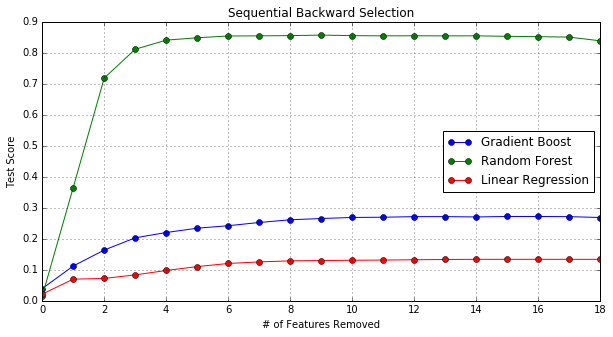

In [7]:
sbs_dict = {}
plt.figure(figsize=(10,5))
names = []
for name,model in models.items():
    names.append(name)
    sbs = SBS(model, k_features=1)
    sbs.fit(X,y)
    k_feat = [len(k)-1 for k in sbs.subsets_]
    sbs_dict[name] = sbs.subsets_
    sbs_feat_subset = sbs.subsets_
    plt.plot(k_feat,sbs.scores_,marker='o')
    plt.xlabel('# of Features Removed')
    plt.ylabel('Test Score')
    plt.grid(True)
plt.title('Sequential Backward Selection')    
plt.legend(names,loc=0)
plt.show()

In [8]:
for name,model in models.items():
    print '################################### {} ##########################################'.format(name)
    if name == 'Random Forest':
        k = 4
    else:
        k = 8
    remove_feats = list(set(list(df.columns[2:-1])) - set(list(df.columns[2:-1][list(sbs_dict[name][k])])))
    pprint(remove_feats)
    print ''

################################### Gradient Boost ##########################################
['precipIntensity',
 'precipAccumulation',
 'apparentTemperatureMax',
 'visibility',
 'precipTypeIsSnow',
 'temperatureMin',
 'precipTypeIsRain',
 'precipProbability']

################################### Random Forest ##########################################
['apparentTemperatureMax', 'apparentTemperatureMin', 'temperatureMin', 'NDVI']

################################### Linear Regression ##########################################
['precipIntensity',
 'precipAccumulation',
 'visibility',
 'pressure',
 'cloudCover',
 'precipTypeIsRain',
 'precipIntensityMax',
 'precipProbability']



## SAVE SBS FEATURE GROUPINGS

In [9]:
with open('data/SBS_feat_set.plk','wb') as f:
    pickle.dump(sbs_dict,f)